In [1]:
import time
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from conv_sparse_model import ConvSparseLayer

from train_conv3d_sparse_model import load_balls_data
from train_conv3d_sparse_model import plot_original_vs_recon
from train_conv3d_sparse_model import plot_filters
from train_conv3d_sparse_model import plot_video

from video_loader import VideoLoader
from video_loader import MinMaxScaler

from IPython.display import HTML

In [2]:
def load_balls_data(batch_size):
    
    with open('ball_videos.npy', 'rb') as fin:
        ball_videos = torch.tensor(np.load(fin)).float()

    batch_size = batch_size
    train_loader = torch.utils.data.DataLoader(ball_videos,
                                               batch_size=batch_size,
                                               shuffle=True)

    return train_loader

In [2]:
def load_bamc_data(batch_size):
    video_path = "/home/cm3786@drexel.edu/bamc_data/"
    transforms = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                                 torchvision.transforms.Resize(size=(160, 90)), 
                                                 MinMaxScaler(0, 255)])
    dataset = VideoLoader(video_path, transform=transforms, num_frames=60)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return train_loader

In [62]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    batch_size = 1
else:
    batch_size = 3*3

# train_loader = load_balls_data(batch_size)
# train_loader = load_bamc_data(batch_size)

# example_data = next(iter(train_loader))

sparse_layer = ConvSparseLayer(in_channels=1,
                               out_channels=32,
                               kernel_size=8,
                               stride=1,
                               padding=0,
                               convo_dim=3,
                               rectifier=True,
                               shrink=0.25,
                               lam=0.5,
                               max_activation_iter=200,
                               activation_lr=1e-2)
model = torch.nn.DataParallel(sparse_layer, device_ids=[1, 2, 3])
model.to(device)

learning_rate = 1e-2
filter_optimizer = torch.optim.Adam(sparse_layer.parameters(),
                                    lr=learning_rate)

In [63]:
example_data[1].shape

torch.Size([6, 1, 60, 90, 160])

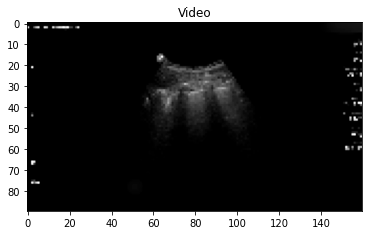

In [54]:
ani = plot_video(example_data[1][1])
HTML(ani.to_html5_video())

In [64]:
for epoch in range(30):
    # for local_batch in train_loader:
    for labels, local_batch in train_loader:
        local_batch = local_batch.to(device)
        t1 = time.perf_counter()
        activations = model(local_batch)
        t2 = time.perf_counter()
        loss = sparse_layer.loss(local_batch, activations)
        print('epoch={}, loss={:.2f}, time={:.2f}'.format(epoch, loss, t2-t1))

        filter_optimizer.zero_grad()
        loss.backward()
        filter_optimizer.step()
        sparse_layer.normalize_weights()

epoch=0, loss=2976.12, time=5.26
epoch=0, loss=1835.29, time=5.26
epoch=0, loss=1855.47, time=5.26
epoch=0, loss=1650.18, time=5.28
epoch=0, loss=1334.59, time=5.27
epoch=0, loss=1440.24, time=5.27
epoch=0, loss=1249.10, time=5.26
epoch=0, loss=1305.98, time=5.26
epoch=0, loss=1321.88, time=5.27
epoch=0, loss=1411.82, time=5.30
epoch=0, loss=1147.24, time=2.67
epoch=1, loss=1388.69, time=5.29
epoch=1, loss=1168.64, time=5.27
epoch=1, loss=1209.71, time=5.26
epoch=1, loss=1079.82, time=5.25
epoch=1, loss=1144.80, time=5.32
epoch=1, loss=1349.25, time=5.27
epoch=1, loss=1400.68, time=5.28
epoch=1, loss=1542.59, time=5.28
epoch=1, loss=1335.57, time=5.25
epoch=1, loss=1140.04, time=5.27
epoch=1, loss=699.54, time=2.68
epoch=2, loss=1253.59, time=5.28
epoch=2, loss=1172.90, time=5.29
epoch=2, loss=1180.05, time=5.26
epoch=2, loss=1171.91, time=5.26
epoch=2, loss=1005.44, time=5.27
epoch=2, loss=1087.02, time=5.26
epoch=2, loss=988.72, time=5.28
epoch=2, loss=1013.65, time=5.26
epoch=2, los

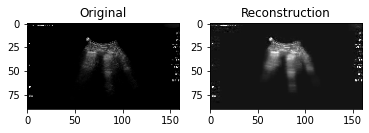

In [47]:
idx=3
activations = sparse_layer(example_data[1][idx:idx+1].to(device))
reconstructions = sparse_layer.reconstructions(
    activations).cpu().detach().numpy()

ani = plot_original_vs_recon(example_data[1][idx:idx+1], reconstructions, idx=0)
HTML(ani.to_html5_video())

In [78]:
def plot_filters(filters):
    num_filters = filters.shape[0]
    ncol = 3
    # ncol = int(np.sqrt(num_filters))
    # nrow = int(np.sqrt(num_filters))
    T = filters.shape[2]
    
    if num_filters // ncol == num_filters / ncol:
        nrow = num_filters // ncol
    else:
        nrow = num_filters // ncol + 1

    fig, axes = plt.subplots(ncols=ncol, nrows=nrow,
                             constrained_layout=True,
                             figsize=(ncol*2, nrow*2))

    ims = {}
    for i in range(num_filters):
        r = i // ncol
        c = i % ncol
        ims[(r, c)] = axes[r, c].imshow(filters[i, 0, 0, :, :],
                                        cmap=cm.Greys_r)

    def update(i):
        t = i % T
        for i in range(num_filters):
            r = i // ncol
            c = i % ncol
            ims[(r, c)].set_data(filters[i, 0, t, :, :])

    return FuncAnimation(plt.gcf(), update, interval=1000/30)

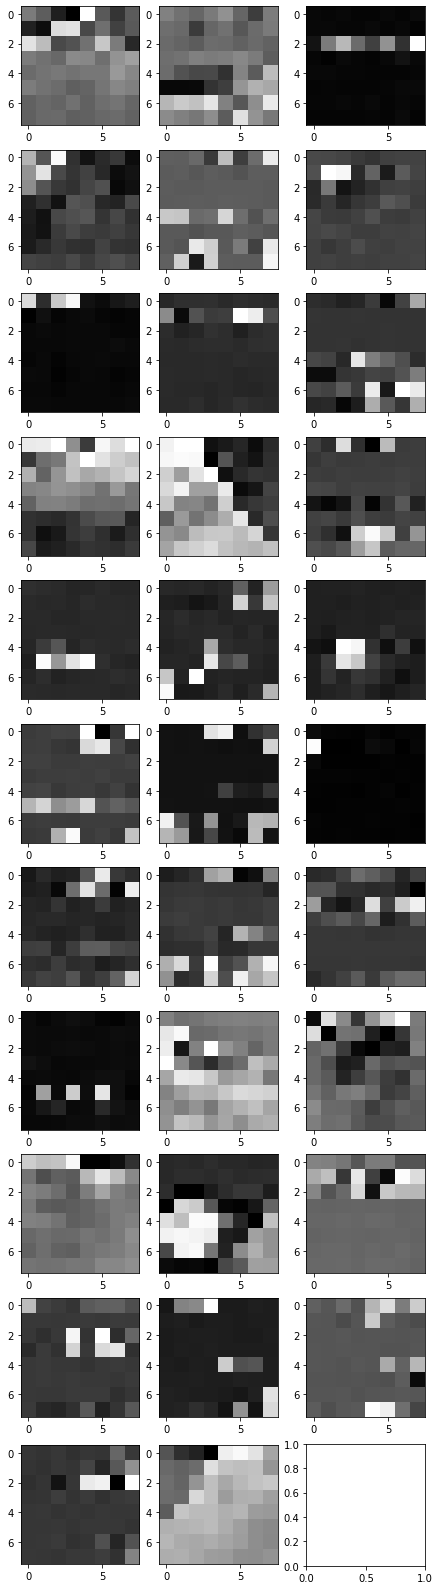

In [79]:
ani = plot_filters(sparse_layer.filters.cpu().detach())
HTML(ani.to_html5_video())